# Installs & Imports

In [1]:
!wget --quiet --no-check-certificate --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1-_PLgM_wxsFf5FiIpWfD_tnkUELu3xFq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-_PLgM_wxsFf5FiIpWfD_tnkUELu3xFq" -O img_align_celeba.zip && rm -rf /tmp/cookies.txt
!unzip -oqqUU img_align_celeba.zip
!mkdir data
!mkdir data/celeba/
!mv img_align_celeba/ data/celeba/

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.utils.data as data
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import random
import os
import numpy as np
from google.colab.patches import cv2_imshow
from pathlib import Path
%matplotlib inline

# Classes & Functions

## Dataset

In [3]:
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __len__(self):
        return self.tensors[0].size(0)
    
    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(Image.fromarray(x))
        y = self.tensors[1][index]
        return x, y

def split_dataset(dataset, train_pctg=0.8):
    n_train = int(len(dataset) * train_pctg)
    n_test = len(dataset) - n_train
    train_subset, test_subset = random_split(dataset, [n_train, n_test])
    return train_subset, test_subset

# ResNetVAE

In [4]:
def conv2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int))
    return outshape

def convtrans2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = ((img_size[0] - 1) * stride[0] - 2 * padding[0] + kernel_size[0],
                (img_size[1] - 1) * stride[1] - 2 * padding[1] + kernel_size[1])
    return outshape

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3 = 8, 32, 64
        self.k1, self.k2, self.k3 = (3, 3), (3, 3), (3, 3)
        self.s1, self.s2, self.s3 = (2, 2), (2, 2), (2, 2)
        self.pd1, self.pd2, self.pd3 = (0, 0), (0, 0), (0, 0)

        # encoding components
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, self.ch3 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(self.ch3 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.ch3, out_channels=self.ch2, kernel_size=self.k3, stride=self.s3, padding=self.pd3),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.ch2, out_channels=self.ch1, kernel_size=self.k2, stride=self.s2, padding=self.pd2),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.ch1, out_channels=3, kernel_size=self.k1, stride=self.s1, padding=self.pd1),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, self.ch3, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(model, train_loader, optimizer, epoch, device='cpu', log_interval=10):
    model.train()
    losses = []
    N_count = 0
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)
        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))
    return losses


def validation(model, test_loader, device='cpu'):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)
            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss
    test_loss /= len(test_loader.dataset)
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return test_loss

In [6]:
def plot(model, x):
    recon_x, z, mu, logvar = model.forward(x.unsqueeze(0).cuda())
    x = np.transpose(x, (1, 2, 0))
    recon_x = np.transpose(recon_x.cpu().detach().numpy().squeeze(), (1, 2, 0))

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    plt.title('original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(recon_x)
    plt.title('reconstructed')
    plt.axis('off')
    plt.show()

# Run

## Get device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print("Using", torch.cuda.device_count(), "GPU!")

cuda
Using 1 GPU!


## Load data

In [8]:
batch_size = 25
transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

celeba_dataset = data.Subset(datasets.ImageFolder('data/celeba', transform), range(5000))
train_subset, test_subset = split_dataset(celeba_dataset, train_pctg=0.8)
train_loader = DataLoader(train_subset, batch_size=batch_size)
valid_loader = DataLoader(test_subset, batch_size=batch_size)

## Instantiate model

In [9]:
resnet_vae = ResNet_VAE(fc_hidden1=64,
                        fc_hidden2=64,
                        drop_p=0.1,
                        CNN_embed_dim=16).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## Train

In [10]:
optimizer = torch.optim.Adam(list(resnet_vae.parameters()), lr=1e-3)
epochs = 20

In [11]:
epoch_train_losses = []
epoch_test_losses = []
for epoch in range(epochs):
    train_losses = train(resnet_vae, train_loader, optimizer, epoch, device=device)
    test_loss = validation(resnet_vae, valid_loader, device=device)

    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(test_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Train Epoch: 1 [250/4000 (6%)]	Loss: 6850306.000000
Train Epoch: 1 [500/4000 (12%)]	Loss: 8243257.000000
Train Epoch: 1 [750/4000 (19%)]	Loss: 6235100.000000
Train Epoch: 1 [1000/4000 (25%)]	Loss: 7109942.000000
Train Epoch: 1 [1250/4000 (31%)]	Loss: 6611015.000000
Train Epoch: 1 [1500/4000 (38%)]	Loss: 7531467.500000
Train Epoch: 1 [1750/4000 (44%)]	Loss: 7843364.000000
Train Epoch: 1 [2000/4000 (50%)]	Loss: 6611801.000000
Train Epoch: 1 [2250/4000 (56%)]	Loss: 7394878.500000
Train Epoch: 1 [2500/4000 (62%)]	Loss: 6418111.500000
Train Epoch: 1 [2750/4000 (69%)]	Loss: 6370372.000000
Train Epoch: 1 [3000/4000 (75%)]	Loss: 6154943.000000
Train Epoch: 1 [3250/4000 (81%)]	Loss: 6569375.500000
Train Epoch: 1 [3500/4000 (88%)]	Loss: 6047949.500000
Train Epoch: 1 [3750/4000 (94%)]	Loss: 6971356.000000
Train Epoch: 1 [4000/4000 (100%)]	Loss: 5790412.500000

Test set (1000 samples): Average loss: 262082.9910

Train Epoch: 2 [250/4000 (6%)]	Loss: 5490671.500000
Train Epoch: 2 [500/4000 (12%)]	Lo

## Eval

In [15]:
resnet_vae.eval();

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


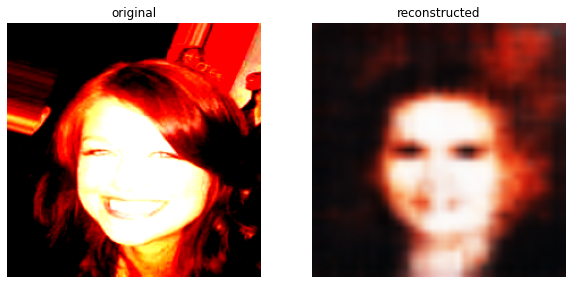

In [13]:
x, _ = train_loader.dataset[0]
plot(resnet_vae, x)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


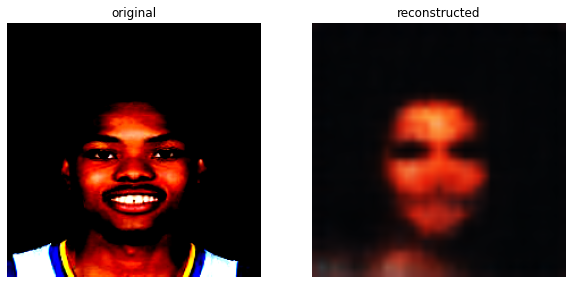

In [14]:
x, _ = train_loader.dataset[50]
plot(resnet_vae, x)